# Attention

## 1. 데이터 준비
- [튜토리얼](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html)

- [torchtext 0.9.0 docs](https://pytorch.org/text/0.9.0/vocab.html#vocab)

In [1]:
!pip uninstall -y torch torchtext
!pip install torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Found existing installation: torch 1.12.0+cu113
Uninstalling torch-1.12.0+cu113:
  Successfully uninstalled torch-1.12.0+cu113
Found existing installation: torchtext 0.13.0
Uninstalling torchtext-0.13.0:
  Successfully uninstalled torchtext-0.13.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:13:32tcmalloc: large alloc 1147494400 bytes == 0x38f2c000 @  0x7f3fa265b615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████               | 1055.7 MB 1.3 MB/s eta 0:12:14tcmalloc: large alloc 1434370048 bytes == 0x7d582000 @  0x7f3fa265b615 0x592b76 0x4df71e 0x59afff 0x5156

In [2]:
import torch
import torchtext

print(torch.__version__) # 1.8.0+cu111
print(torchtext.__version__) # 0.9.0

1.8.0+cu111
0.9.0


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torchtext.legacy.datasets import Multi30k
# from torchtext.legacy.data import Field, BucketIterator, Iterator

import spacy
import numpy as np

import random
import math
import time

### 데이터셋 다운로드

In [4]:
# 난수 생성
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
# 문장을 토큰화하는 모듈 설치
# spacy 라이브러리: 문장의 토큰화, 태깅 등 전처리 기능을 위한 라이브러리

!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 27.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 6.9 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [6]:
# 튜토리얼 따라하기
# https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html

import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import io

url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.fr.gz', 'train.en.gz')
val_urls = ('val.fr.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.fr.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

fr_tokenizer = get_tokenizer('spacy', language='fr')
en_tokenizer = get_tokenizer('spacy', language='en')

train.fr.gz: 100%|██████████| 604k/604k [00:00<00:00, 35.3MB/s]
train.en.gz: 100%|██████████| 569k/569k [00:00<00:00, 80.6MB/s]
val.fr.gz: 100%|██████████| 23.0k/23.0k [00:00<00:00, 13.6MB/s]
val.en.gz: 100%|██████████| 21.6k/21.6k [00:00<00:00, 5.54MB/s]
test_2016_flickr.fr.gz: 100%|██████████| 22.3k/22.3k [00:00<00:00, 6.65MB/s]
test_2016_flickr.en.gz: 100%|██████████| 21.1k/21.1k [00:00<00:00, 4.99MB/s]
/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "fr" could not be loaded, trying "fr_core_news_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')
/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [7]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

fr_vocab = build_vocab(train_filepaths[0], fr_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

def data_process(filepaths):
  raw_fr_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_fr, raw_en) in zip(raw_fr_iter, raw_en_iter):
    fr_tensor_ = torch.tensor([fr_vocab[token] for token in fr_tokenizer(raw_fr)],
                            dtype=torch.long)
    en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                            dtype=torch.long)
    data.append((fr_tensor_, en_tensor_))
  return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128
PAD_IDX = fr_vocab['<pad>']
BOS_IDX = fr_vocab['<bos>']
EOS_IDX = fr_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  fr_batch, en_batch = [], []
  for (fr_item, en_item) in data_batch:
    fr_batch.append(torch.cat([torch.tensor([BOS_IDX]), fr_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  fr_batch = pad_sequence(fr_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return fr_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

print("device :",device)

device : cuda


**주의 : input data의 shape**

In [9]:
sample = next(iter(train_iter))
sample[0].size(), sample[1].size() # (seq_len , batch_size)

(torch.Size([39, 128]), torch.Size([39, 128]))

In [10]:
# 첫 번째 train data 출력해보기 [프랑스어, 영어]

def idx2sen(data, lan):
    res = []
    if lan == "fr":
        for idx in data[0]:
            res.append(fr_vocab.itos[idx])

    elif lan == "en":
        for idx in data[1]:
            res.append(en_vocab.itos[idx])
    
    return " ".join(res)


fr_sen = idx2sen(train_data[0], lan="fr")
en_sen = idx2sen(train_data[0], lan="en")
print(train_data[0][0])
print("프랑스어: ", fr_sen)

print(train_data[0][1])
print("영어: ", en_sen)

tensor([  26,   85,   34,  225,   31,   91,   75,    9, 1202,    5,    4])
프랑스어:  Deux jeunes hommes blancs sont dehors près de buissons . 

tensor([  20,   26,   16, 1170,  809,   18,   58,   85,  337, 1340,    6,    5])
영어:  Two young , White males are outside near many bushes . 



## 2. 모델 정의

참고 자료
- https://techblog-history-younghunjo1.tistory.com/493
- 밑시딥 2권

### Encoder 개선 

seq2seq 한계 : encoder의 출력이 고정된 길이의 벡터이다. 
- 문장 길이에 관계없이 항상 같은 길이의 벡터로 변환
- 긴 문장의 경우 정보가 잘 담기지 못하는 문제가 *있음*

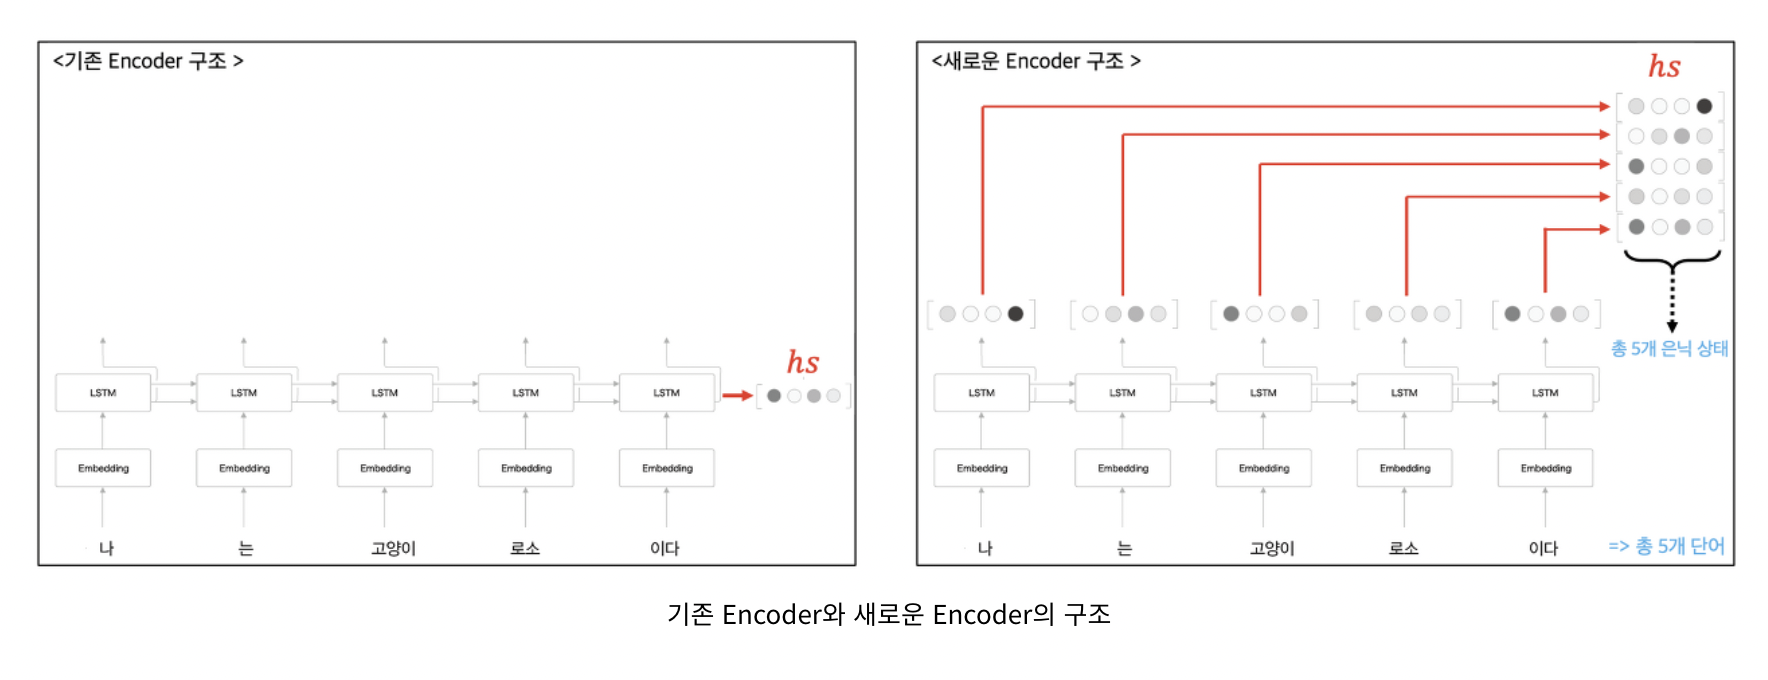

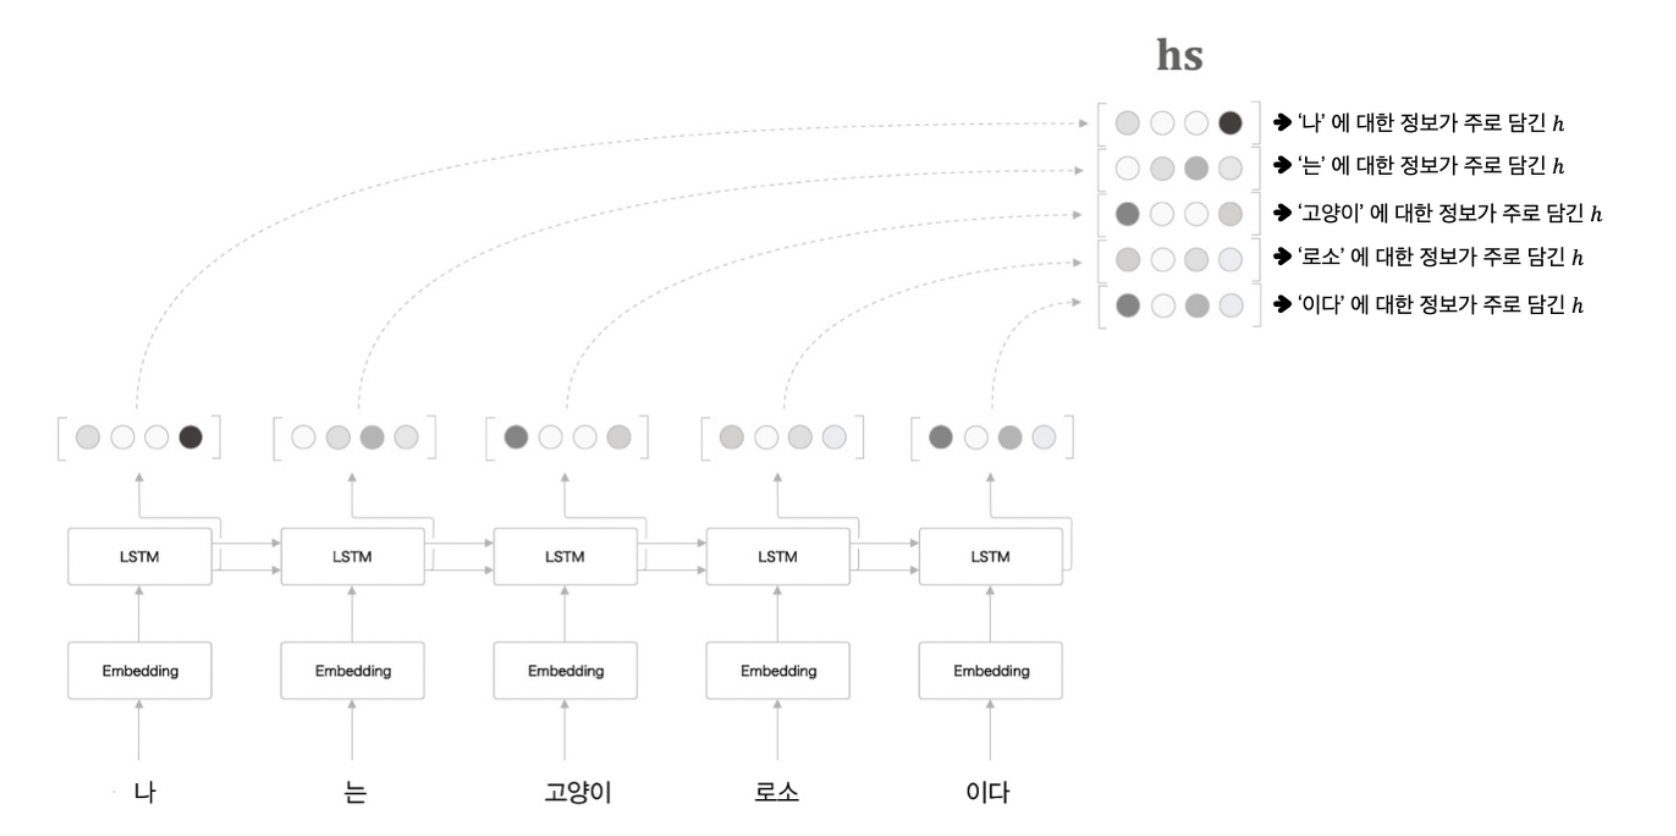

**Seq2Seq with no Attention(Encoder)**

In [ ]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,src: Tensor) -> Tuple[Tensor]:

        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded) # output: containing the output features (h_t) from the last layer of the LSTM, for each t.

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        # Attention이 아닌 Seq2Seq Encoder에서는 outputs을 사용하지 않음
        return outputs, hidden

class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,
                src: Tensor,
                trg: Tensor,
                teacher_forcing_ratio: float = 0.5) -> Tensor:

        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        ############ Seq2Seq without Attention #############
        #_ , (hidden, cell) = self.encoder(src)
        ####################################################

        ############ Seq2Seq with Attention ################
        encoder_outputs , (hidden, cell) = self.encoder(src)
        ####################################################
        

        input = trg[0,:]
        # |input| = (batch_size,)

        for t in range(1, max_len):
            output, (hidden, cell) = self.decoder(input, hidden, cell, encoder_outputs)

            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)

        return outputs


### Decoder 개선

Encoder의 모든 timestep의 정보를 활용할 수 있게 변경

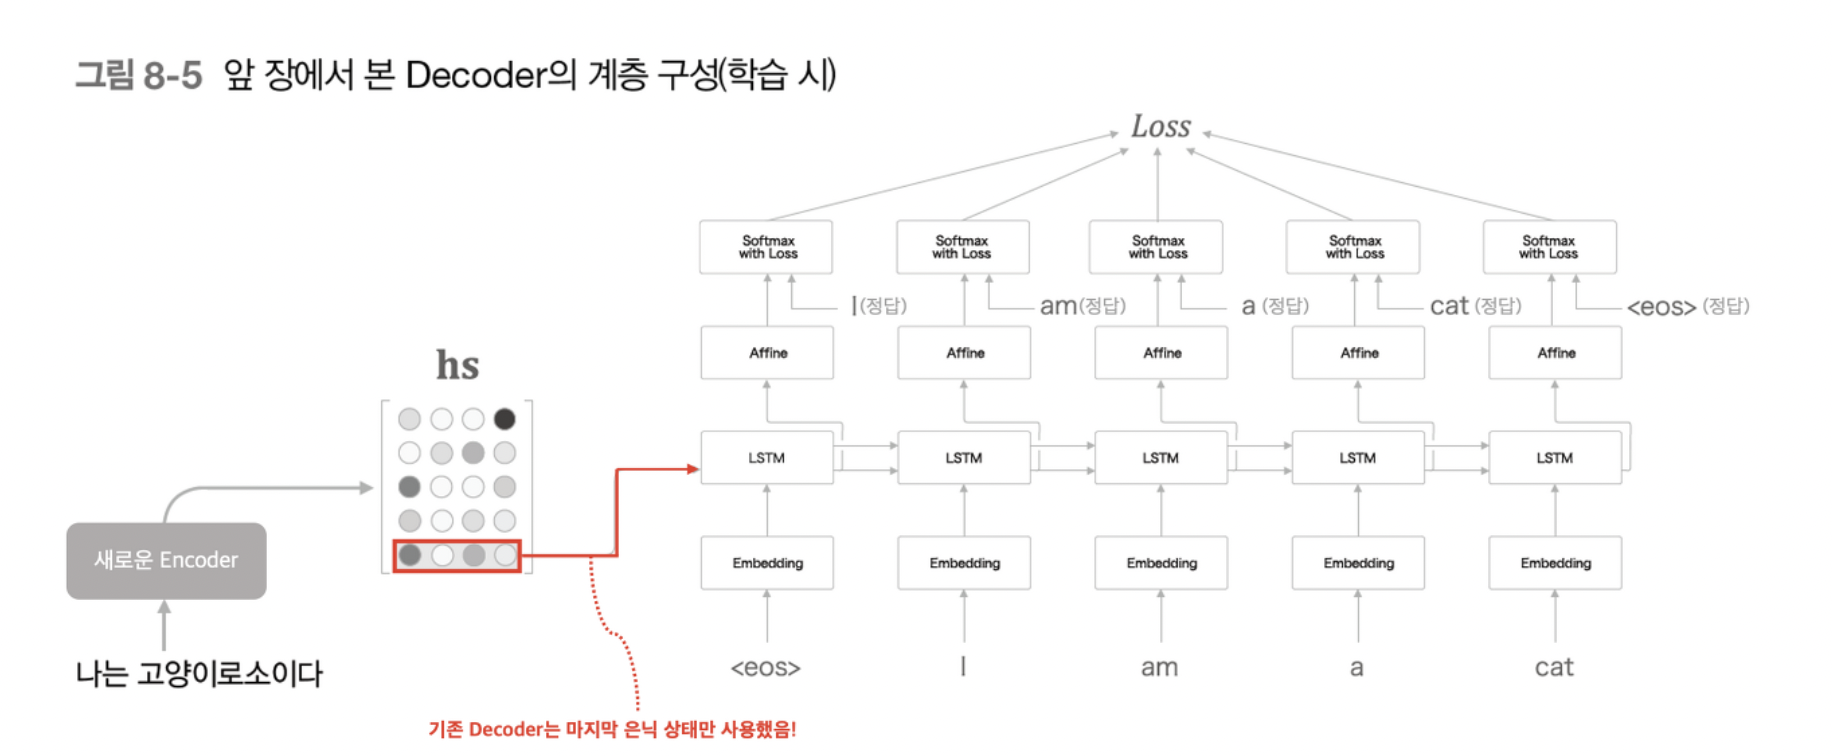

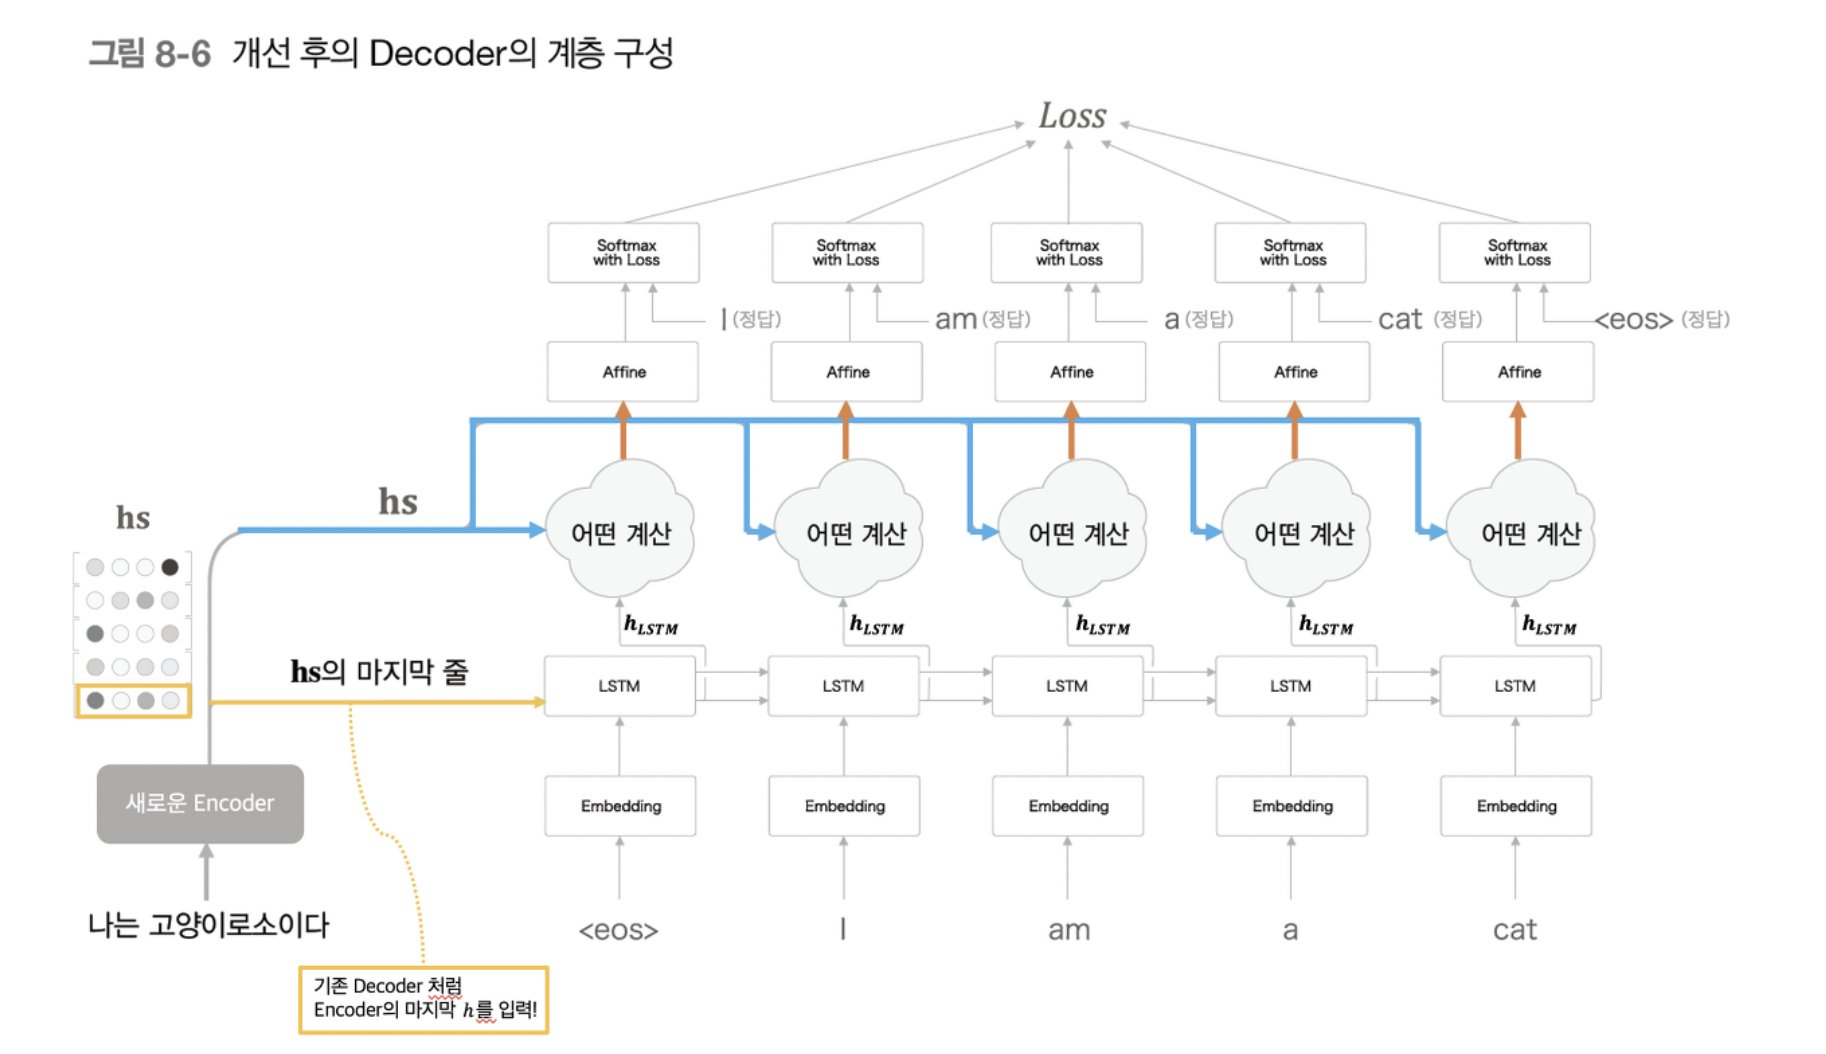

**Seq2Seq with no Attention(Decoder)**

In [ ]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 hid_dim: int,
                 num_layers: int,
                 dropout: float):
        super().__init__()

        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(self.output_dim, self.emb_dim)
        
        self.rnn = nn.LSTM(
            input_size = self.emb_dim,
            hidden_size = self.hid_dim,
            num_layers = self.num_layers,
            dropout = self.dropout
        )
        self.fc = nn.Linear(hid_dim, self.output_dim)
        self.dropout = nn.Dropout(dropout)
    
    ############ Decoder 개선 #############
    # 1. seq2seq에서는 encoder의 out을 사용하지 않고, 마지막 state의 hn, cn 만 사용 -> attention은 모든 timestep의 hidden state가 필요하기 때문에 encoder의 output을 인자로 받아야 함
    # 2. Attention에서 score 구하는 과정 추가.(뒤에)
    # 3. score를 반영한 값을 layer에 넣는다.(뒤에)

    #def forward(self, input, hn, cn):
    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        out, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        pred = self.fc(out.squeeze(0))
        return pred, (hidden, cell)


class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, (hidden, cell) = self.encoder(src)

        input = trg[0,:]

        for t in range(1, trg_len):
            ########### without Attention #############
            #output, (hn, cn) = self.decoder(input, hn, cn)
            #####################################

            ########### with Attention #############
            output, (hidden, cell) = self.decoder(input, hidden, cell, encoder_outputs)
            #####################################
            
            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1
        return outputs


### Attention

**Attention 목표**

: 정보를 Alignment 하고 싶다. = 단어 혹은 문구의 대응 관계를 파악하고 싶다. ('고양이=cat')

=> Decoder가 'I'를 출력할 때, hs에서 '나'에 해당되는 벡터를 선택하고 싶다.

=> 이러한 선택 작업을 attention을 통해 하고자 함


=> 문제점 : 선택하는 작업은 미분을 할 수 없다. (5개 중에 1개 고르는 과정을 backprop할 수 없다.)

=> 아이디어 : 선택하는 작업을 미분 가능하게 대체하자 -> 하나를 선택하는 게 아니라 모든 것을 선택하되, **가중치**를 별도로 계산한다. 즉 모든 hs 정보를 다 가져오되, 중요한 건 더 많이 가져올 수 있는 비율값을 구하자.



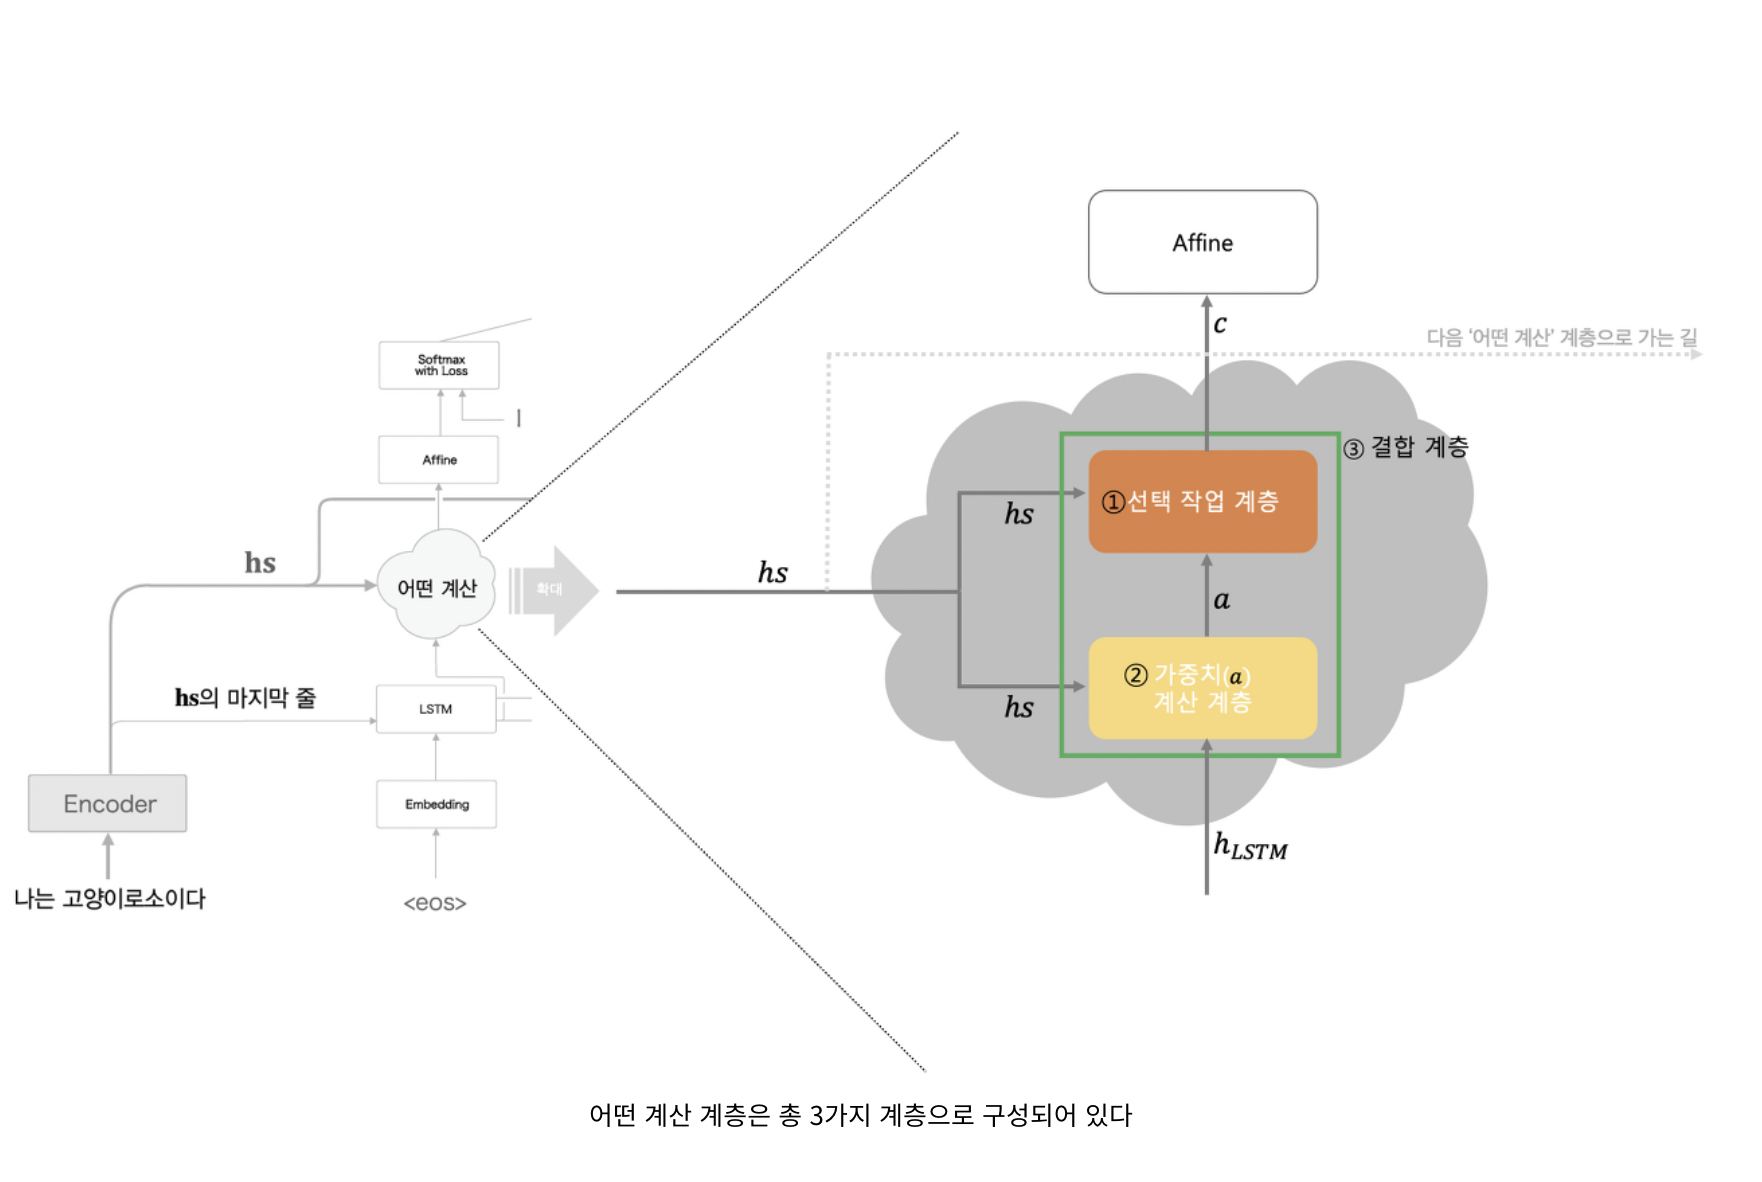

**어떤계산(Attention)의 흐름**
1. 가중치 계산 계층
   - 입력 2개 : decoder의 현재 timestep의 hidden state(d_hs_t) ,  encoder의 모든 hidden states(e_hs = [e_hs_1, e_hs_2, ..., e_hs_m]) 
   - d_hs_t와 e_hs의 각 hs에 대한 가중치를 구한다.
   - 가중치를 구하는 방법은 여러가지가 있다.
      - dot
      - general
      - concat
      - location-base
      - (s_t = Query /  h_i = Keys / W_a, W_b는 학습 가능한 가중치 행렬)
      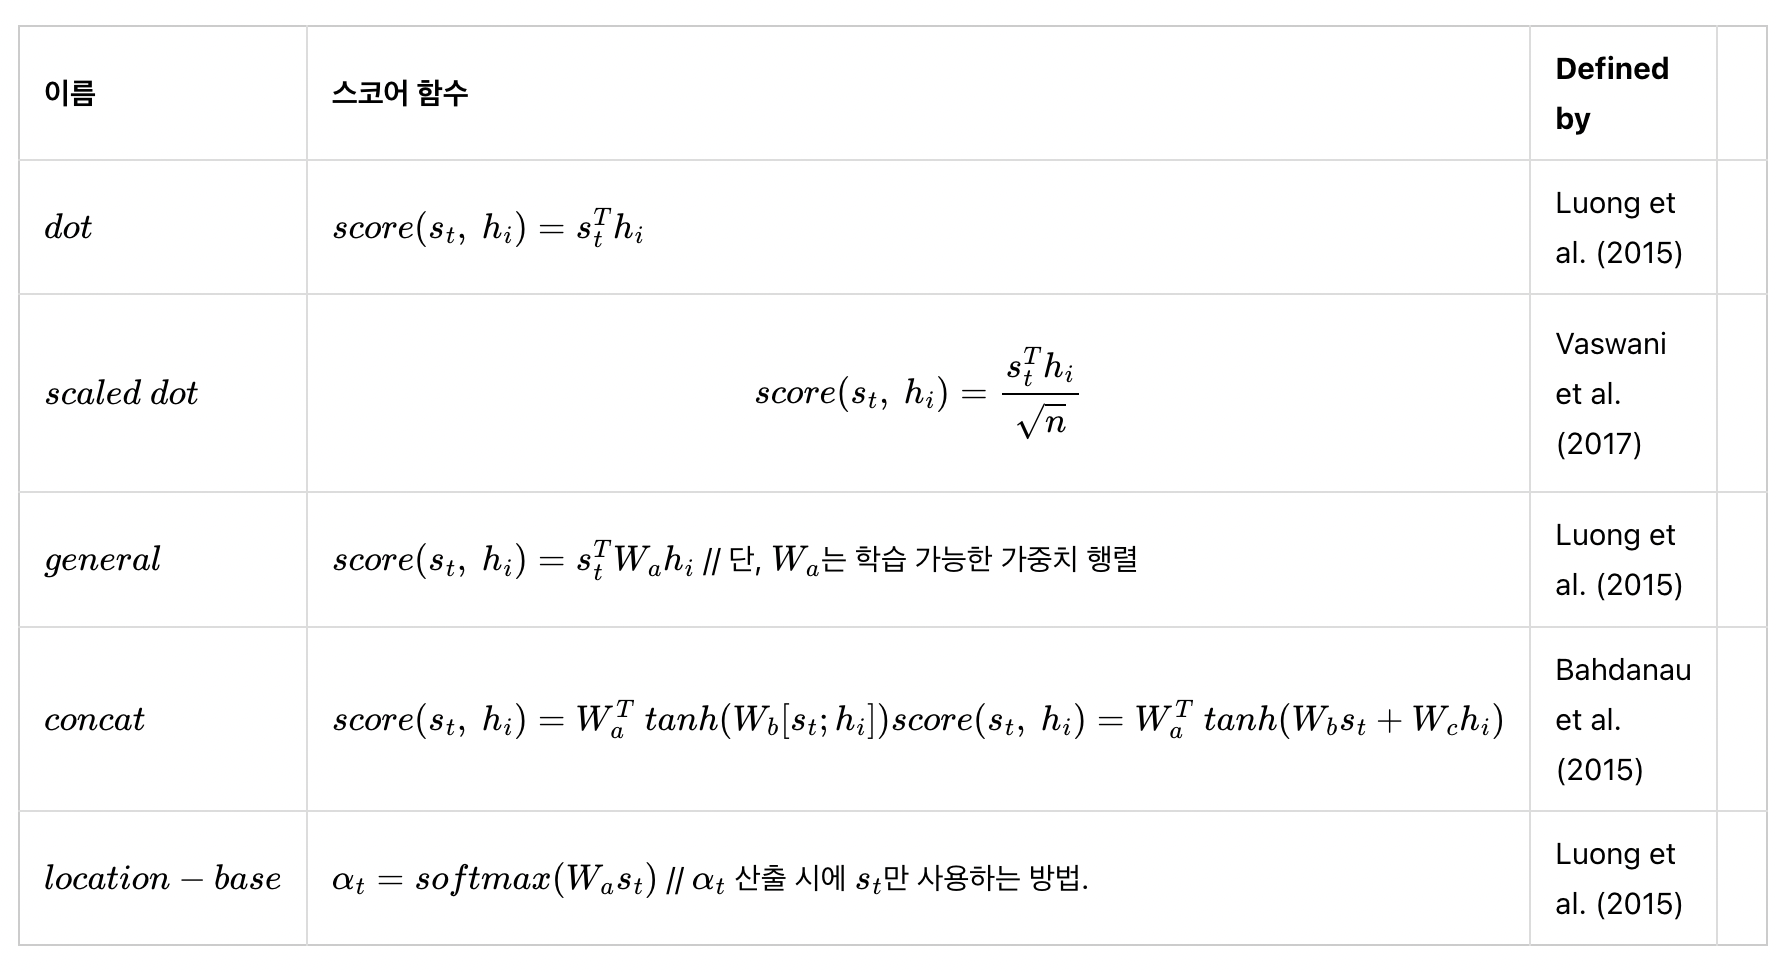
    - output : 가중치 a 
      - scaled dot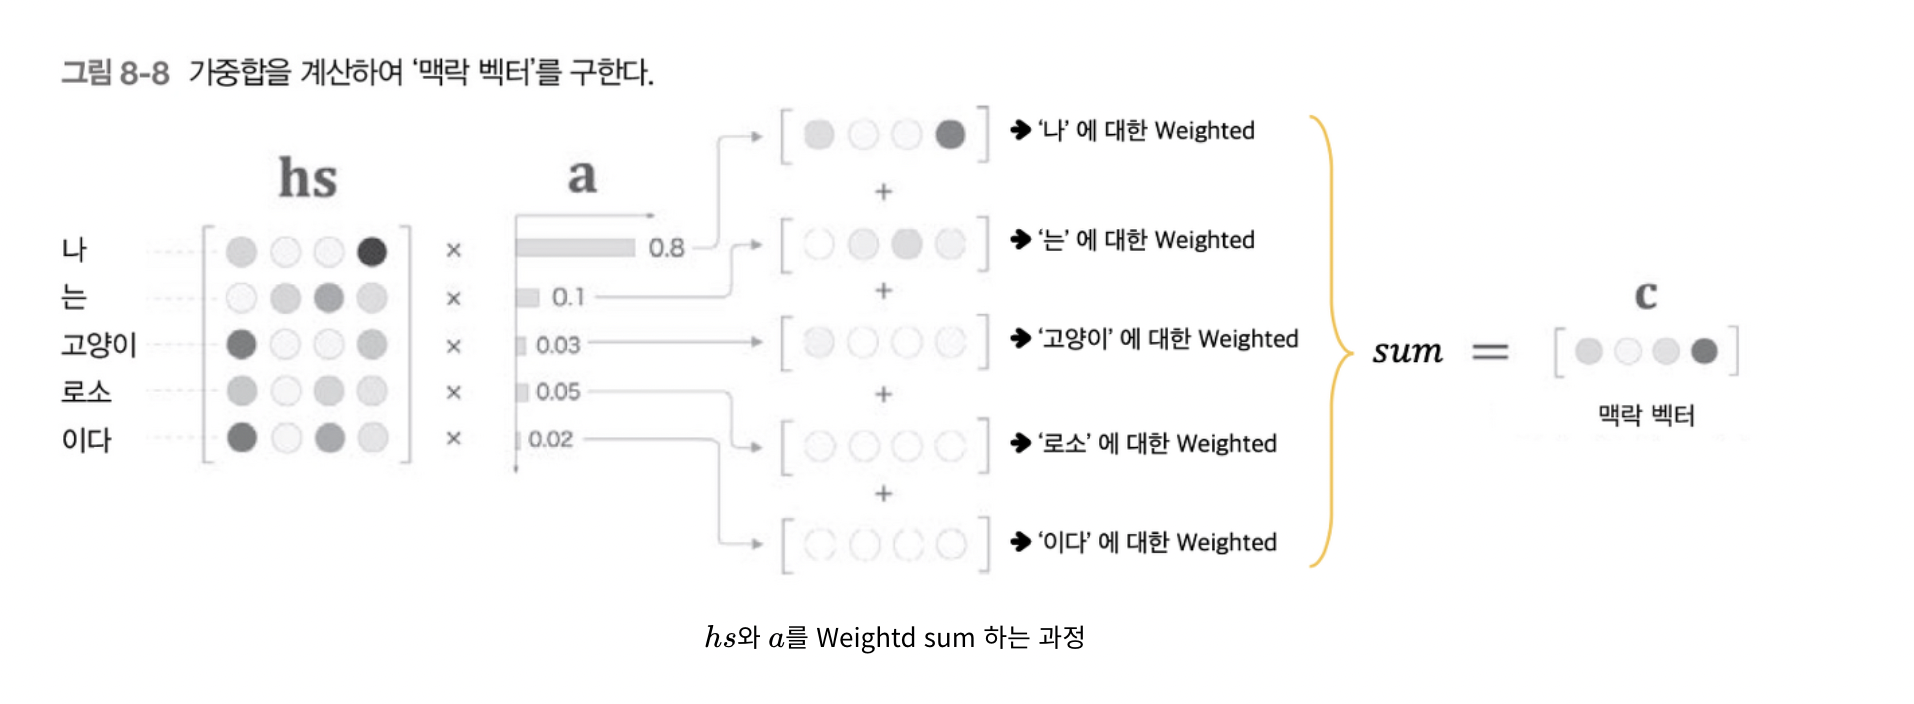




2. 선택 작업 계층
   - 입력 2개 : encoder의 모든 hidden states, 가중치 계산 계층에서의 output
   - encoder의 모든 hidden states에 가중치 결과값을 적용하여 가중합을 계산하여 맥락벡터 c를 구한다.

In [124]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 hid_dim: int,
                 num_layers: int,
                 dropout: float):
        super().__init__()

        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(self.output_dim, self.emb_dim)
        
        self.rnn = nn.LSTM(
            input_size = self.emb_dim,
            hidden_size = self.hid_dim,
            num_layers = self.num_layers,
            dropout = self.dropout,
        )
        self.fc = nn.Linear(hid_dim, self.output_dim)
        self.dropout = nn.Dropout(dropout)

    ######## Attention 추가 ######### # score를 받아서 value랑 합쳐서 context vector 만들어줌
    def _weighted_encoder_rep(self, decoder_hidden, encoder_outputs) -> Tensor:

        # |decoder_hidden| = (num_layers, batch_size, d_hidden_size)
        # |encoder_output| = (src_seq_len, batch_size, 2 * e_hidden_size)

        a = self.attention(decoder_hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        return weighted_encoder_rep
    ################################


    def forward(self, input, decoder_hidden, cell, encoder_output):
        # |input| = (batch_size,)
        # |decoder_hidden| = (num_layers, batch_size, d_hidden_size)
        # |cell| = (num_layers, batch_size, d_hidden_size)
        # |encoder_output| = (src_seq_len, batch_size, 2 * e_hidden_size)

        #print("decoder input size (128) : ", input.shape)
        input = input.unsqueeze(0)
        # |input| = (1, batch_size)

        embedded = self.dropout(self.embedding(input))
        # |embedded| = (1, batch_size, emb_dim)

        ####### Attention 추가 #########
        weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden, encoder_output) # cell은 안보내도 되나..?
        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)
        out, (decoder_hidden, cell) = self.rnn(rnn_input, (decoder_hidden.unsqueeze(0), cell.unsqueeze(0)))
        ################################

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)
        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))
        
        return output, decoder_hidden.squeeze(0), cell.squeeze(0)


In [ ]:
class Attention(nn.Module): # Query, Key 받아서 score를 내놓는
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim

        self.attn = nn.Linear(self.attn_in, attn_dim)

    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:
        # |decoder_hidden| = (num_layers, batch_size, d_hidden_size)
        # |encoder_output| = (src_seq_len, batch_size, 2 * e_hidden_size)
        
        # scr_len : src 문장 길이
        src_len = encoder_outputs.shape[0]

        
        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1 , 1)
        # |decoder_hidden.unsqueeze(1)| = (num_layers, 1, batch_size, d_hidden_size)
        # |decoder_hidden.unsqueeze(1)| = (num_layers, 1, batch_size, d_hidden_size)
        
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        attention = torch.sum(energy, dim=2)

        return F.softmax(attention, dim=1)


### 결론 : Seq2Seq with attention

In [11]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor


class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 num_layers : int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, num_layers=num_layers, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src: Tensor) -> Tuple[Tensor]:

        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden


class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim

        self.attn = nn.Linear(self.attn_in, attn_dim)

        self.attention_weight = None

    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:

        # |decoder_hidden| = (batch_size, d_hidden_size)
        # |encoder_outputs| = (src_seq_len, batch_size, 2*e_hidden_size)

        src_len = encoder_outputs.shape[0]

        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)
        # |decoder_hidden.unsqueeze(1)| = (batch_size, 1, d_hidden_size)
        # |repeated_decoder_hidden| = (batch_size, src_seq_len, d_hidden_size)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # |encoder_outputs| = (batch_size, src_seq_len, 2*e_hidden_size)

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))
        # |torch.cat(repeated_decoder_hidden, encoder_outputs, dim=2)| = (batch_size, src_seq_len, d_hidden_size + 2*e_hidden_size)
        # |self.attn(torch.cat(repeated_decoder_hidden, encoder_outputs, dim=2))| = (batch_size, src_seq_len, attn_dim)



        attention = torch.sum(energy, dim=2)
        # |attention| = (batc_size, src_seq_len) = (128, 31)
        # print('attention shape: ', attention.shape)
        self.attention_weight = F.softmax(attention, dim=1)
        return F.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 num_layers : int, 
                 dropout: int,
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, hidden_size = dec_hid_dim, num_layers = num_layers)

        #self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)
        self.out = nn.Linear(dec_hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:

        # |decoder_hidden| = (batch_size, d_hidden_size)
        # |encoder_outputs| = (src_seq_len, batch_size, 2*e_hidden_size)
        
        a = self.attention(decoder_hidden, encoder_outputs)
        # |a| = (batc_size, src_seq_len) = (128, 31)
        

        a = a.unsqueeze(1)
        # |a| = (batc_size, 1, src_seq_len) = (128, 1, 31)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # |encoder_outputs| = (batch_size, src_seq_len, 2*e_hidden_size)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)
        # |weighted_encoder_rep| = (batch_size, 1, 2*e_hidden_size)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)
        # |weighted_encoder_rep| = (1, batch_size, 2*e_hidden_size)

        return a, weighted_encoder_rep


    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tuple[Tensor]:

        # |input| = (batch_size)
        # |decoder_hidden| = (batch_size, d_hidden_size)
        # |encoder_outputs| = (src_seq_len, batch_size, 2*hidden_size)

        input = input.unsqueeze(0)
        # |input| = (1, batch_size)

        embedded = self.dropout(self.embedding(input))
        # print("embedded size: ", embedded.shape)
        # |embedded| = (1, batch_size, emb_dim) = (1, 128, 32)

        self.a, weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)
        # |weighted_encoder_rep| = (1, batch_size, 2*e_hidden_size) -> context vector

        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)
        # | rnn_input | = (1, batch_size, emb_dim + 2 * e_hidden_size)


        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))
        # | output | = (1, batch_size, decoder_hidden)
        # |decoder_hidden| = (1, batch_size, decoder_hidden)= (1, 128, 64)

        embedded = embedded.squeeze(0)
        # |embedded| = (batch_size, emb_dim) = (128, 32)

        output = output.squeeze(0)
        # | output | = (batch_size, decoder_hidden)

        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)
        # |weighted_encoder_rep| = (batch_size, 2*e_hidden_size) -> context vector

        #output = self.out(torch.cat((output,
        #                             weighted_encoder_rep,
        #                             embedded), dim = 1))
        # |output| = (batch_size, emb_dim + decoder_hidden + 2*e_hidden_size)
        output = self.out(output)
        # |output| = (batch_size, output_dim)
        

        return output, decoder_hidden.squeeze(0)


class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.attention_weights = None

    def forward(self,
                src: Tensor,
                trg: Tensor,
                teacher_forcing_ratio: float = 0.5) -> Tensor:
        attention_weights = []

        # |src| = (src_seq_len , batch_size)
        # |tgt| = (tgt_seq_len, batch_size)
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)
        # print("encoder_outputs shape: ", encoder_outputs.shape)
        # print("hidden ", hidden.shape)
        # |encoder_outputs| = (src_seq_len, batch_size, 2*hidden_size)
        # |hidden| = (batch_size, hidden_size)
        

        # first input to the decoder is the <sos> token
        input = trg[0,:]
        # |input| = (batch_size)

        for t in range(1, max_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
            attention_weights.append(self.decoder.attention.attention_weight)
            
        self.attention_weights = torch.stack(attention_weights, dim=0)
        return outputs

## 3. Trainig

In [12]:
INPUT_DIM = len(fr_vocab)
OUTPUT_DIM = len(en_vocab)
# ENC_EMB_DIM = 256
# DEC_EMB_DIM = 256
# ENC_HID_DIM = 512
# DEC_HID_DIM = 512
# ATTN_DIM = 64
# ENC_DROPOUT = 0.5
# DEC_DROPOUT = 0.5

ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
NUM_LAYERS = 1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, NUM_LAYERS, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, NUM_LAYERS, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)


def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

optimizer = optim.Adam(model.parameters())


def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,510,430 trainable parameters


In [13]:
# Adam optimizer로 학습 최적화
optimizer = optim.Adam(model.parameters())

# 파라미터 수
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

# loss 계산 시 뒷 부분 패딩은 무시
PAD_IDX = en_vocab.stoi['<pad>']

# cross-entropy loss
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

The model has 1,510,430 trainable parameters


In [14]:
import math
import time


def train(model: nn.Module,
          iterator: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0

    for _, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        #print(src.shape, trg.shape)

        optimizer.zero_grad()

        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


In [15]:
import matplotlib.pyplot as plt
# 첫 번째 train data 출력해보기 [프랑스어, 영어]

def idx2char(idx, lan):
    if lan == "fr":
        return fr_vocab.itos[idx]

    elif lan == "en":
        return en_vocab.itos[idx]

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


def evaluate(model: nn.Module,
             iterator: torch.utils.data.DataLoader,
             criterion: nn.Module, attn_map=False):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for _, (src, trg) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            ori_trg = trg
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

            if attn_map:
                  d = model.attention_weights
                  d = np.array(d[:, 0, :].cpu()) # [d_seq_len, 128, 31]
                  attention_map = d

                  # 출력하기 위해 반전
                  #attention_map = attention_map[:,::-1]
                  #src = src[:,::-1]

                  print(src.shape, ori_trg.shape)
                  row_labels = [idx2char(i, 'fr') for i in src[:, 0]]
                  column_labels = [idx2char(i, 'en') for i in ori_trg[:,0]]
                  #column_labels = column_labels[1:]

                  visualize(attention_map, row_labels, column_labels)

        

    return epoch_loss / len(iterator)

In [16]:
def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

test_loss = evaluate(model, test_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

Epoch: 01 | Time: 0m 42s
	Train Loss: 6.008 | Train PPL: 406.724
	 Val. Loss: 5.509 |  Val. PPL: 246.968
Epoch: 02 | Time: 0m 42s
	Train Loss: 5.510 | Train PPL: 247.085
	 Val. Loss: 5.523 |  Val. PPL: 250.353
Epoch: 03 | Time: 0m 41s
	Train Loss: 5.509 | Train PPL: 246.982
	 Val. Loss: 5.530 |  Val. PPL: 252.152
Epoch: 04 | Time: 0m 42s
	Train Loss: 5.510 | Train PPL: 247.031
	 Val. Loss: 5.535 |  Val. PPL: 253.324
Epoch: 05 | Time: 0m 41s
	Train Loss: 5.510 | Train PPL: 247.032
	 Val. Loss: 5.537 |  Val. PPL: 253.981
Epoch: 06 | Time: 0m 41s
	Train Loss: 5.509 | Train PPL: 247.021
	 Val. Loss: 5.541 |  Val. PPL: 255.011
Epoch: 07 | Time: 0m 43s
	Train Loss: 5.509 | Train PPL: 246.970
	 Val. Loss: 5.543 |  Val. PPL: 255.504
Epoch: 08 | Time: 0m 42s
	Train Loss: 5.509 | Train PPL: 247.018
	 Val. Loss: 5.549 |  Val. PPL: 256.949
Epoch: 09 | Time: 0m 41s
	Train Loss: 5.509 | Train PPL: 246.986
	 Val. Loss: 5.550 |  Val. PPL: 257.232
Epoch: 10 | Time: 0m 41s
	Train Loss: 5.477 | Train PPL

## Inference

torch.Size([39, 128]) torch.Size([32, 128])


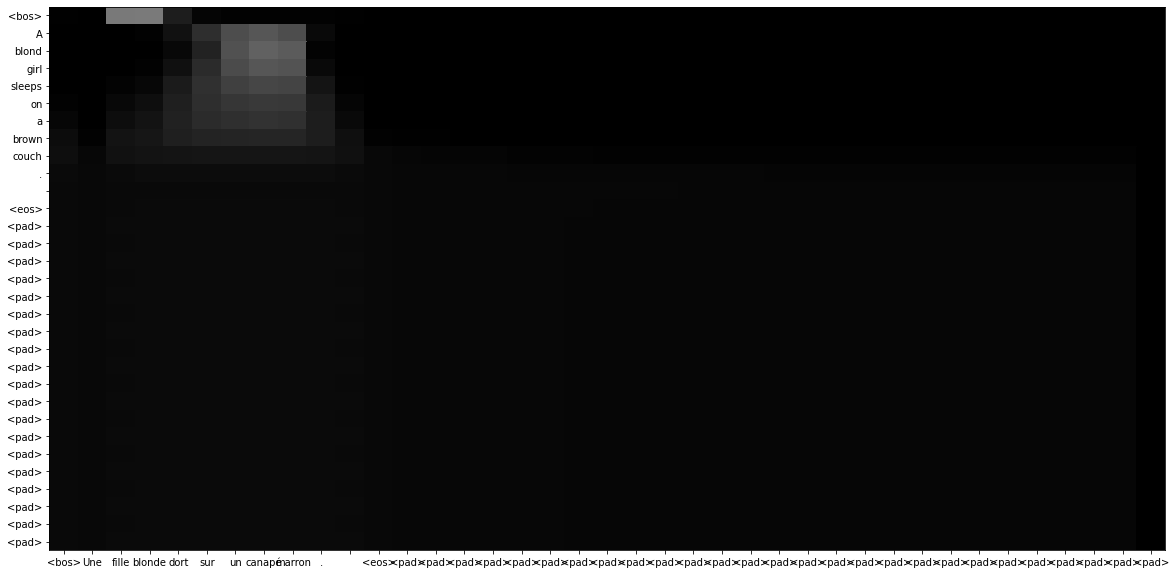

torch.Size([35, 128]) torch.Size([31, 128])


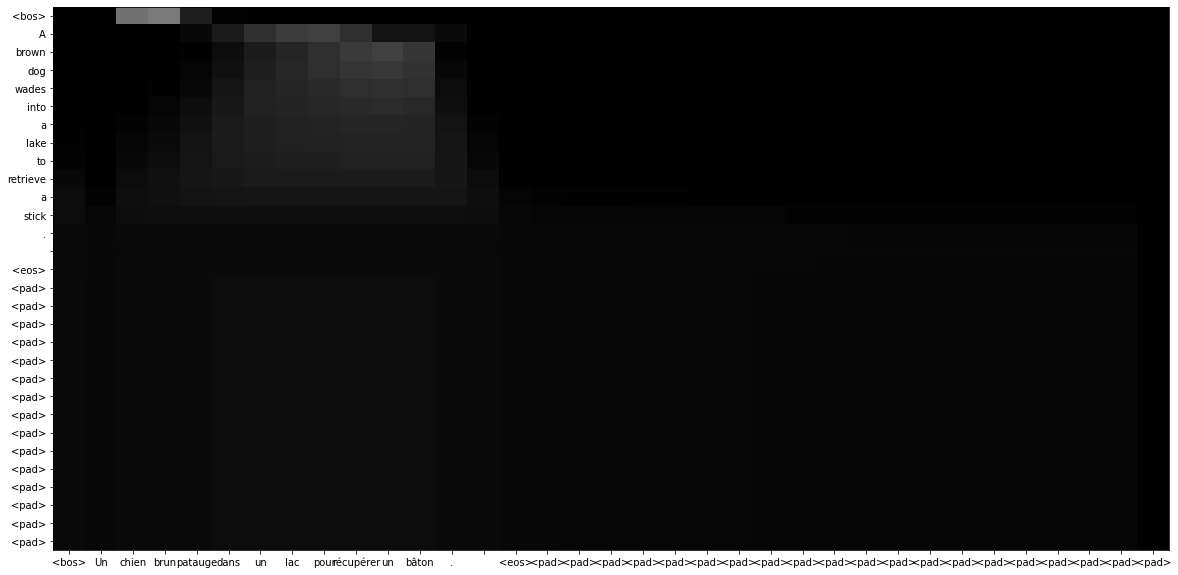

torch.Size([32, 128]) torch.Size([27, 128])


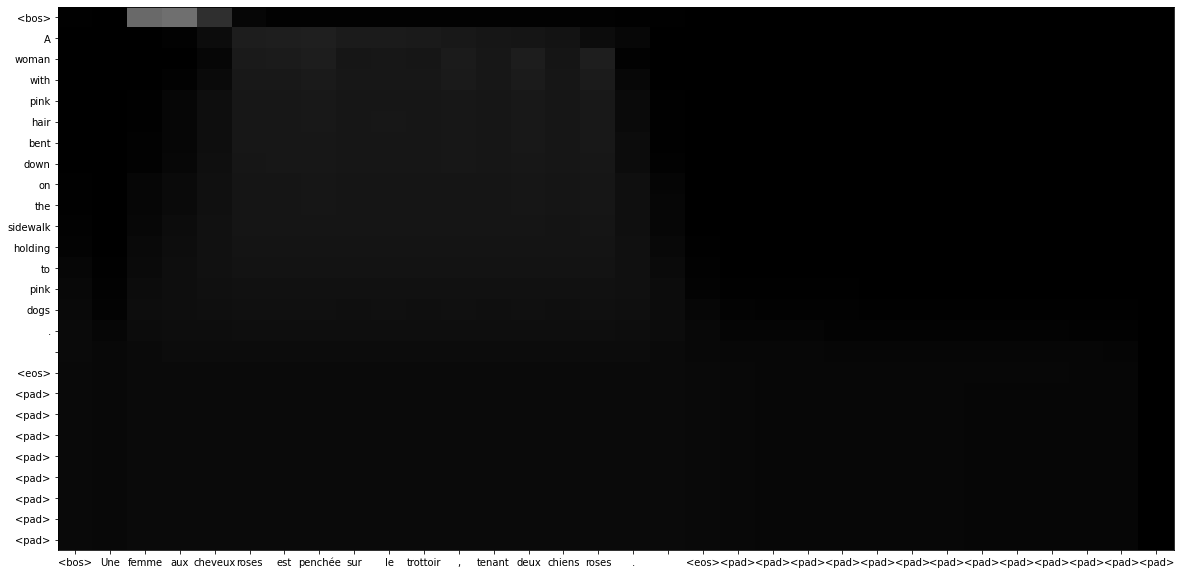

torch.Size([34, 128]) torch.Size([25, 128])


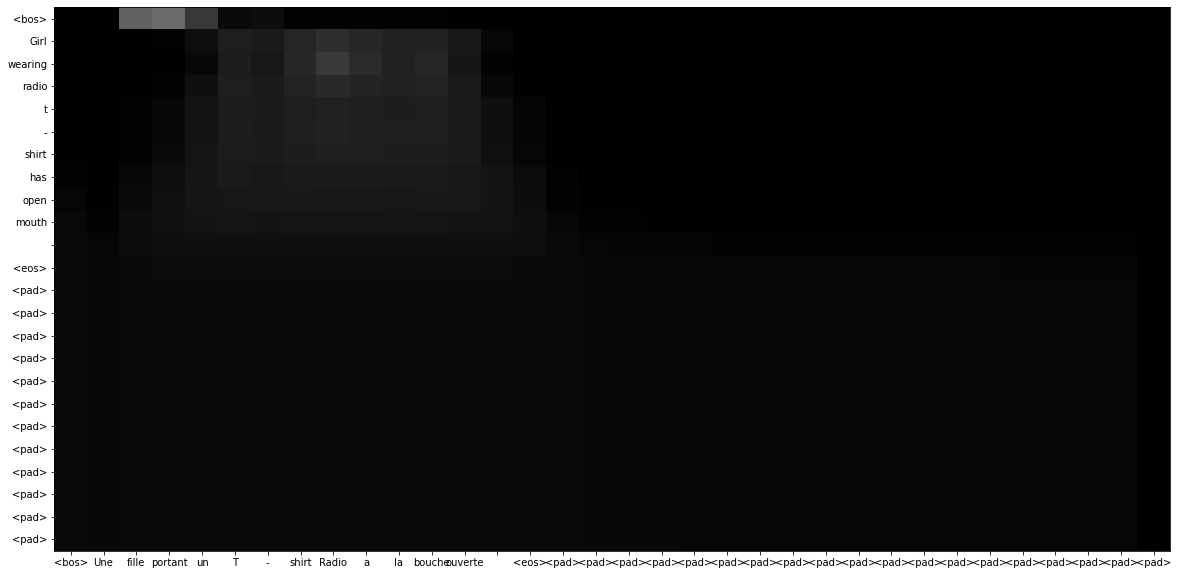

torch.Size([38, 128]) torch.Size([36, 128])


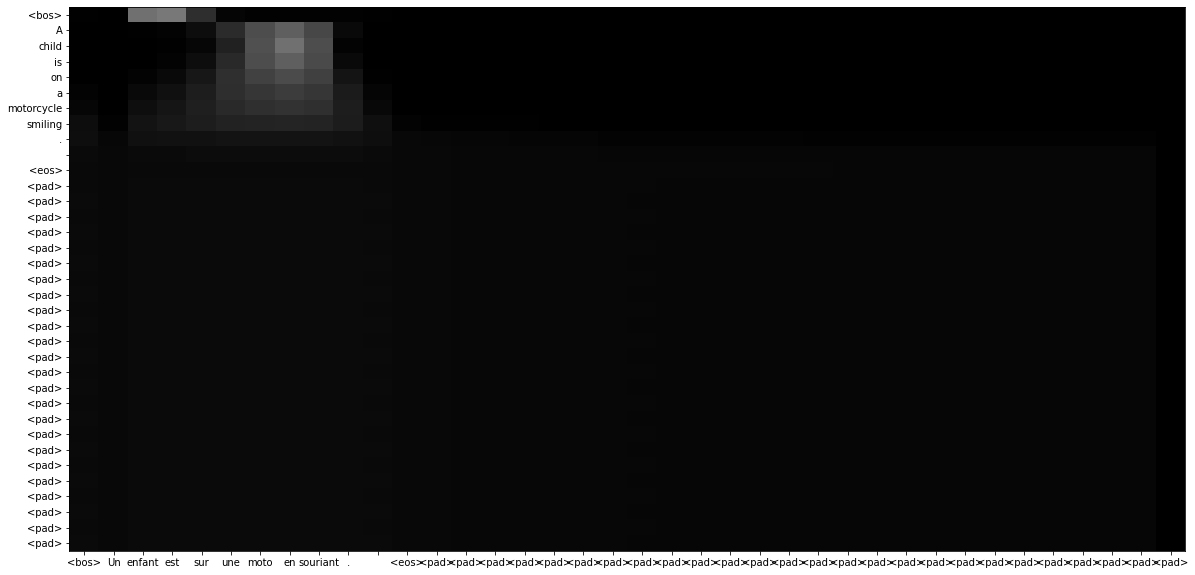

torch.Size([33, 128]) torch.Size([31, 128])


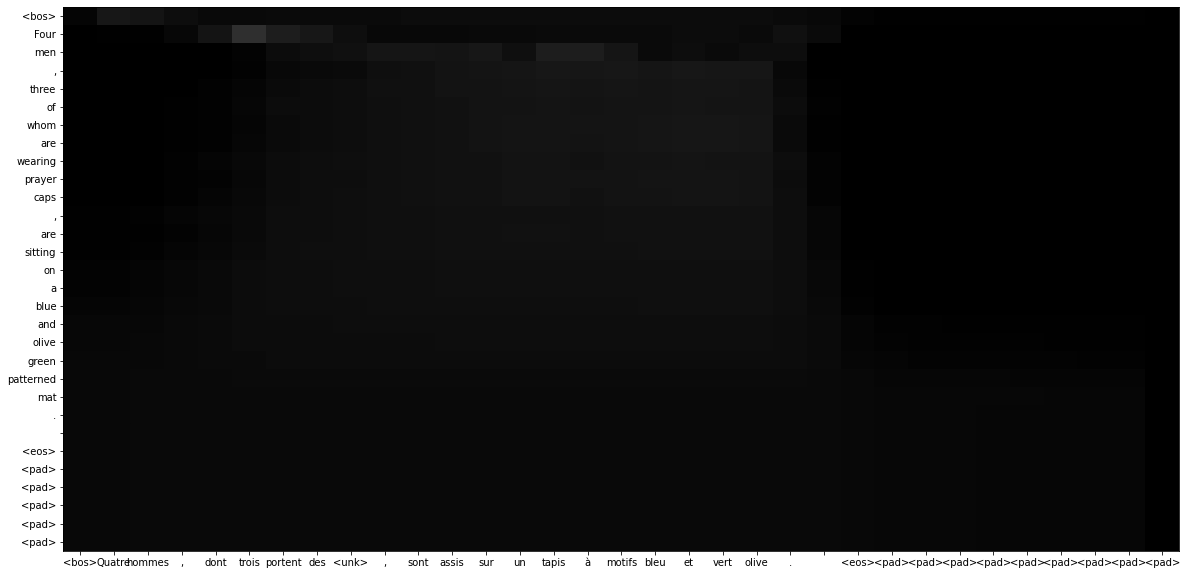

torch.Size([39, 128]) torch.Size([36, 128])


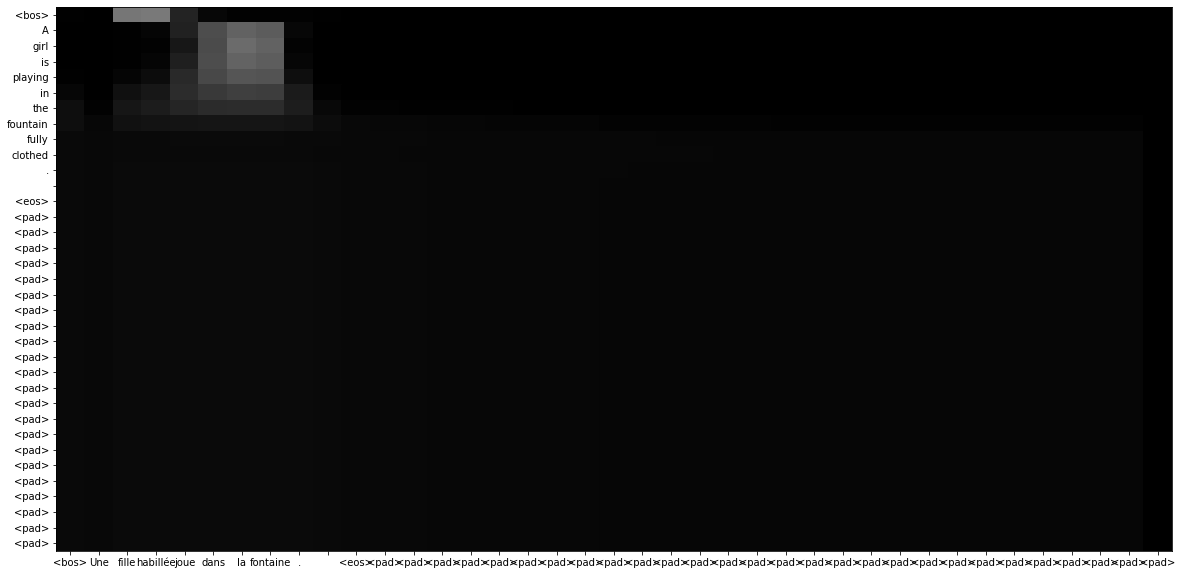

torch.Size([28, 104]) torch.Size([30, 104])


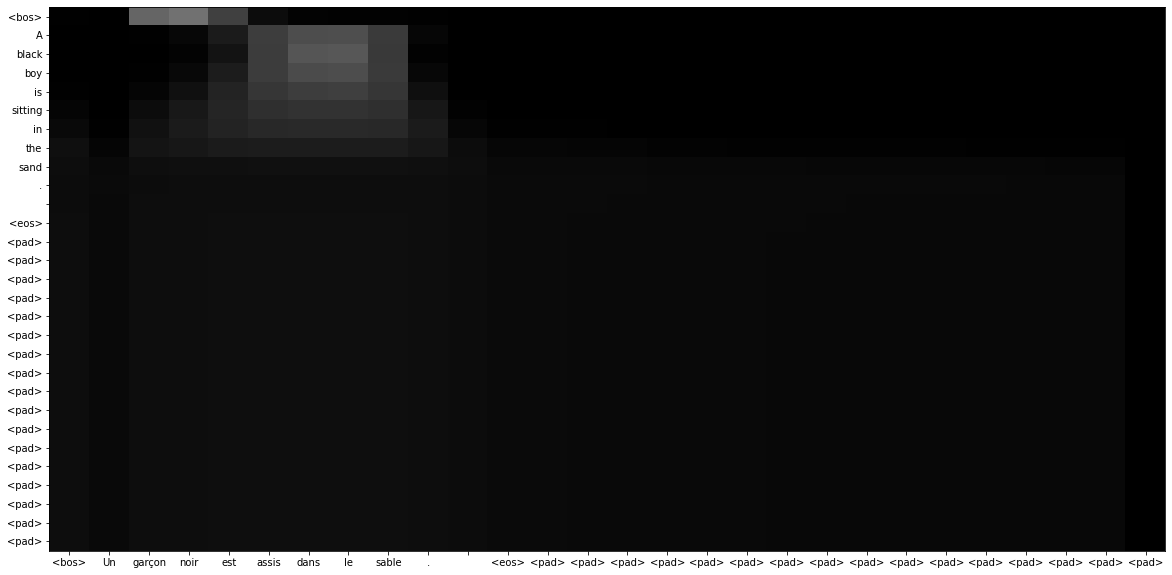

Test Loss: 4.711 | Test PPL: 111.115


In [17]:
## 모델 테스트

#model.load_state_dict(torch.load(SAVE_PATH))

test_loss = evaluate(model, test_iter, criterion, attn_map=True)
print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

# test data attention map

In [22]:
# 번역(translation) 함수

# def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        # nlp = spacy.load('de')
        nlp = spacy.load('fr')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    # tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    tokens = ['<sos>'] + tokens + ['<eos>']
    print(f"전체 소스 토큰: {tokens}")

    # src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_indexes = [src_vocab.stoi[token] for token in tokens]
    print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    print(src_tensor.shape)

    # 인코더(endocer)에 소스 문장을 넣어 문맥 벡터(context vector) 계산
    with torch.no_grad():
        encoded_output, hidden = model.encoder(src_tensor)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    # trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    trg_indexes = [trg_vocab.stoi['<sos>']]

    for i in range(max_len):
        # 이전에 출력한 단어가 현재 단어로 입력될 수 있도록
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoded_output)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        # if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
        if pred_token == trg_vocab.stoi['<eos>']:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    # trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:]

In [23]:
src = fr_tokenizer("Bonne nuit.") # 영어로 Good night
# src = src[::-1]
print(f'소스 문장: {src}')
print("모델 출력 결과:", " ".join(translate_sentence(src, fr_vocab, en_vocab, model, device)))

소스 문장: ['Bonne', 'nuit', '.']
전체 소스 토큰: ['<sos>', 'bonne', 'nuit', '.', '<eos>']
소스 문장 인덱스: [0, 2090, 276, 5, 3]
torch.Size([5, 1])
모델 출력 결과: Two men are are a the street . 
 <eos>


In [24]:
# train data에 있던 문장으로 테스트

src = fr_tokenizer("Deux jeunes hommes blancs sont dehors près de buissons.")
print(f'소스 문장: {src}')
print("모델 출력 결과:", " ".join(translate_sentence(src, fr_vocab, en_vocab, model, device)))

# Two young , White males are outside near many bushes . 

소스 문장: ['Deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']
전체 소스 토큰: ['<sos>', 'deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.', '<eos>']
소스 문장 인덱스: [0, 68, 85, 34, 225, 31, 91, 75, 9, 1202, 5, 3]
torch.Size([12, 1])
모델 출력 결과: Two men are are are are are are are are are in the the the the the the . . 
 <eos>
